In [1]:
!python -m pip install "../."
# !python -m pip install matplotlib

Processing /home/daniil/program/python/project/ImgDoc
  Preparing metadata (setup.py) ... done
  Created wheel for imgdoc: filename=imgdoc-0.0.4-py3-none-any.whl size=12245 sha256=8463a9e873056e528063e864e8f90e68c0c906b8fa2d6fdb33fb18e3719c5d0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-215z8aph/wheels/fb/1a/ed/7d9f75c4ac33138e7c2a11154029a6594122b85a7ed546b6bf
Successfully built imgdoc
  Attempting uninstall: imgdoc
    Found existing installation: imgdoc 0.0.4
    Uninstalling imgdoc-0.0.4:
      Successfully uninstalled imgdoc-0.0.4

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pytesseract
from img_doc.extractors.word_extractors import BaseWordExtractor
from img_doc.data_structures import Word
import numpy as np
from typing import List

class TesseractWordExtractor(BaseWordExtractor):
    def extract_from_img(self, img: np) -> List[Word]:
        tesseract_bboxes = pytesseract.image_to_data(
            config="-l rus",
            image=img,
            output_type=pytesseract.Output.DICT)
        word_list = []
        for index_bbox, level in enumerate(tesseract_bboxes["level"]):
            if level == 5:
                word = Word(text = tesseract_bboxes["text"][index_bbox])
                word.set_point_and_size({
                    "x_top_left":tesseract_bboxes["left"][index_bbox],
                    "y_top_left":tesseract_bboxes["top"][index_bbox],
                    "width":tesseract_bboxes["width"][index_bbox],
                    "height": tesseract_bboxes["height"][index_bbox],
                })
                word_list.append(word)
        return word_list

In [15]:
from img_doc.data_structures import Image
import os

image = Image()
image.set_img_from_path(os.path.join("img", "8.jpg"))

word_ext = TesseractWordExtractor()
words = word_ext.extract_from_img(image.img)
print(words)

[<img_doc.data_structures.document.word.Word object at 0x7f6d043af520>, <img_doc.data_structures.document.word.Word object at 0x7f6cedaaa740>, <img_doc.data_structures.document.word.Word object at 0x7f6cedaab370>, <img_doc.data_structures.document.word.Word object at 0x7f6cedaabeb0>, <img_doc.data_structures.document.word.Word object at 0x7f6cedac2bf0>, <img_doc.data_structures.document.word.Word object at 0x7f6cedac0ac0>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda89330>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda8b430>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda89390>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda8ab00>, <img_doc.data_structures.document.word.Word object at 0x7f6d043e3e20>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda150f0>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda156f0>, <img_doc.data_structures.document.word.Word object at 0x7f6ceda16b60>, <img_

In [16]:
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
kmeanext = KMeanBlockExtractor()


[<img_doc.data_structures.document.block.Block object at 0x7f6cf040ac50>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac1fc0>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2440>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2530>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac31c0>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac3130>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2470>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac24a0>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2b60>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac28c0>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2860>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2800>, <img_doc.data_structures.document.block.Block object at 0x7f6cedac2cb0>, <img_doc.data_structures.document.block.Block obje

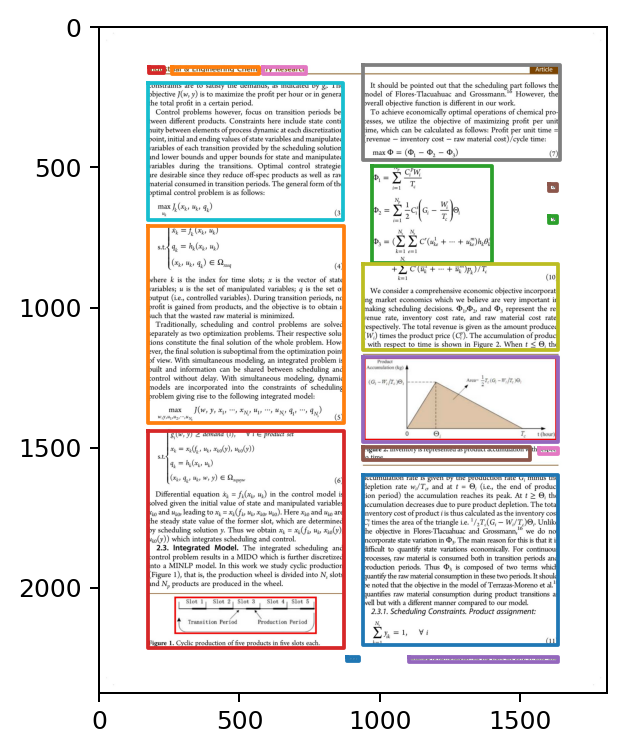

In [17]:
import matplotlib.pyplot as plt

color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
plt.imshow(image.img)

blocks = kmeanext.extract_from_word(words)
print(blocks)
for block in blocks:
    x0 = block.segment.x_top_left
    y0 = block.segment.y_top_left
    x1 = block.segment.x_bottom_right
    y1 = block.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])

In [29]:
import matplotlib.pyplot as plt

color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
# plt.imshow()
blocks2 = kmeanext.extract_from_word(blocks[4].words)

<Figure size 1152x864 with 0 Axes>

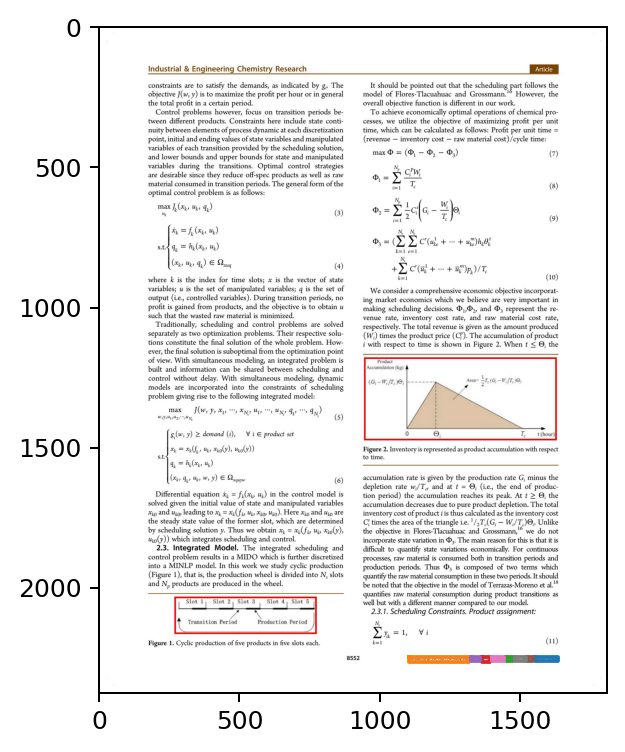

In [30]:
color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
plt.imshow(image.img)
for block in blocks2:
    x0 = block.segment.x_top_left
    y0 = block.segment.y_top_left
    x1 = block.segment.x_bottom_right
    y1 = block.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])